In [1]:
# Dependancies. Uncomment to automatically install.
# %pip install rosbags
# %pip install pandas
# %pip install numpy
# %pip install matplotlib

In [2]:
import utils.rosbags_converter as rc
from utils.seatrac_enums import CST_E
import utils.plotter_utils as p_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

/home/claytonsmith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Settings
- RELOAD: If true, converts rosbags. Otherwise assumes rosbags are already converted
- ROSBAGS_DIR: Directory where your rosbags are stored. Can contain multiple bags
- SAVES_DIR: The directory to save converted csv files (to save time reloading)
- VERBOSE: Print non-essential values

In [3]:
RELOAD = False
VERBOSE = False
ROSBAGS_DIR = "../../bag"
SAVES_DIR = ROSBAGS_DIR+"/converted_bags"
ROSMSGS_DIR = "../../cougars-ros2/src"

In [4]:
# Convert Rosbags

if RELOAD:
    print("converting rosbags")
    dataframes = p_utils.get_dataframes(
        rosbags_dir=ROSBAGS_DIR, rosmsgs_dir=ROSMSGS_DIR, csv_dir=SAVES_DIR,
        keywords=None, topics=None,verbose=VERBOSE)
else:
    print("loading dataframes")
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=None, verbose=VERBOSE)
    if len(dataframes)==0:
        raise RuntimeError("Lenth of dataframes is 0. Dataframes may not be loaded")
print("dataframes loaded")

loading dataframes
dataframes loaded


---

In [5]:
# converts ros header.stamp.sec and header.stamp.nanosec into pandas Timestamps objects
# and adds a new column "timestamp" to 
p_utils.insert_timestamps(dataframes)

coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-00
coug3_bluey/converted__SO_5.0_multi-2025-04-04-20-07-24
coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-41
coug3_bluey/converted__SO_5.3_multi-2025-04-04-20-39-55
coug3_bluey/converted__SO_5.4_multi-2025-04-04-20-45-36
coug3_bluey/converted__SO_5.1_multi-2025-04-04-20-19-51
base_station/converted__SO_4.0_multi_base_station
base_station/converted__SO_5.2_multi
base_station/converted__SO_5.4_multi
base_station/converted__SO_2.0_base_station
base_station/converted__SO_5.1_multi
base_station/converted__SO_multi_3.0
base_station/converted__SO_5.5_multi
base_station/converted__SO_5.0_multi
coug1/converted__-2025-04-18-14-29-36


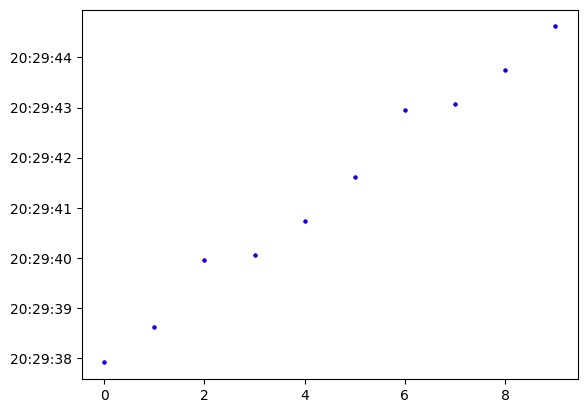

coug1/converted__so_5.0_multi-2025-04-18-15-55-38


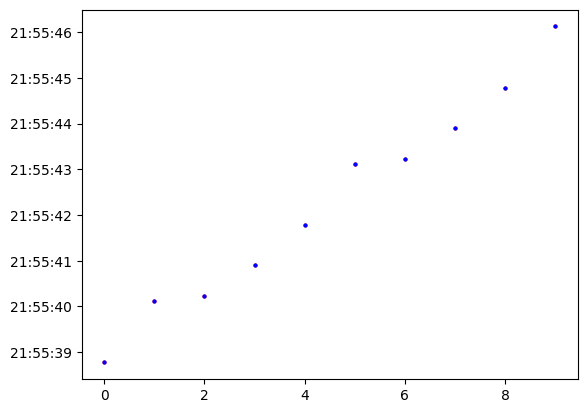

coug1/converted__so_5.5_multi-2025-04-18-16-42-57


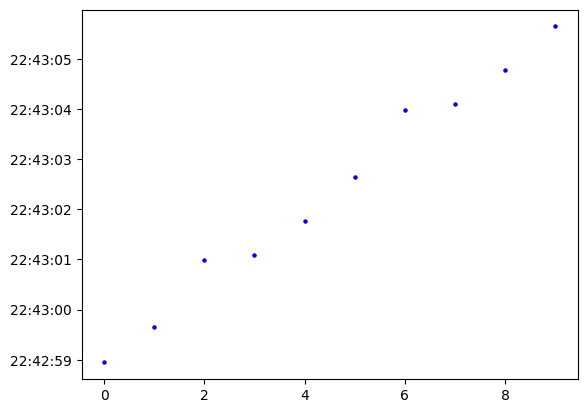

coug1/converted__SO_3.0_multi_cougs-2025-04-18-14-40-44


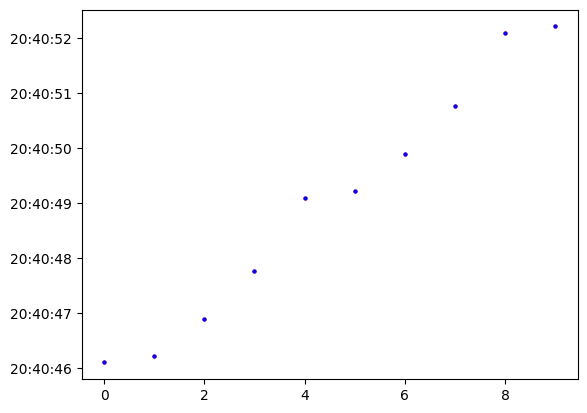

coug1/converted__so_5.1_multi-2025-04-18-16-09-08


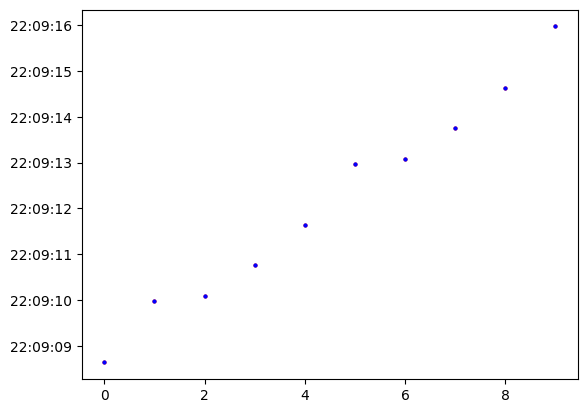

coug1/converted__so_5.4_multi-2025-04-18-16-34-01


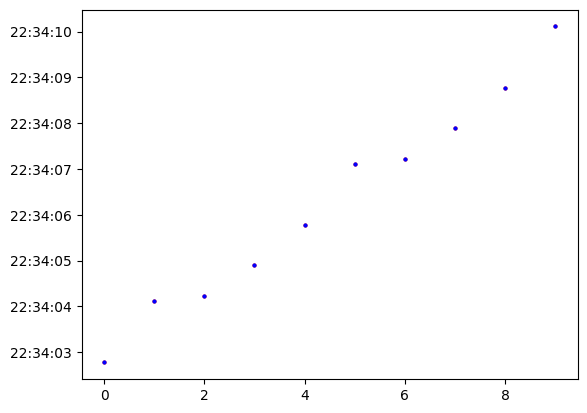

coug1/converted__so_4.0_multi-2025-04-18-15-04-05


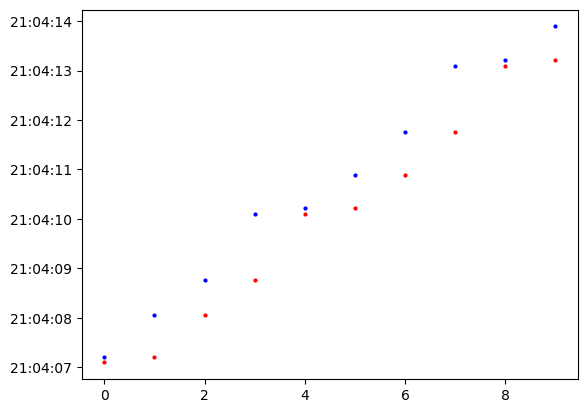

coug2/converted__SO_3.0_multi_cougs-2025-04-18-14-40-49


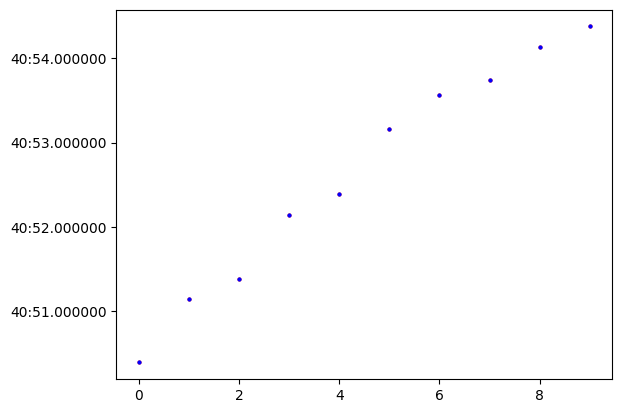

coug2/converted__SO_1.0-2025-04-18-14-04-01


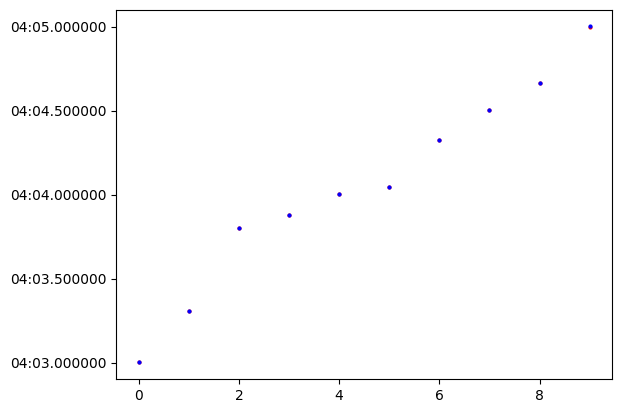

coug2/converted__SO_2.0-2025-04-18-14-15-52


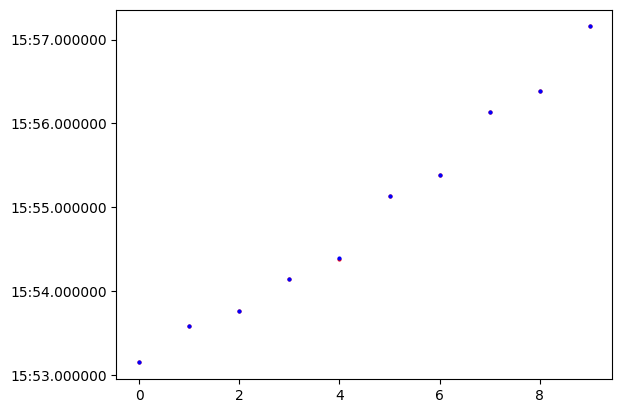

coug2/converted__SO_4.0_multi-2025-04-18-15-04-08


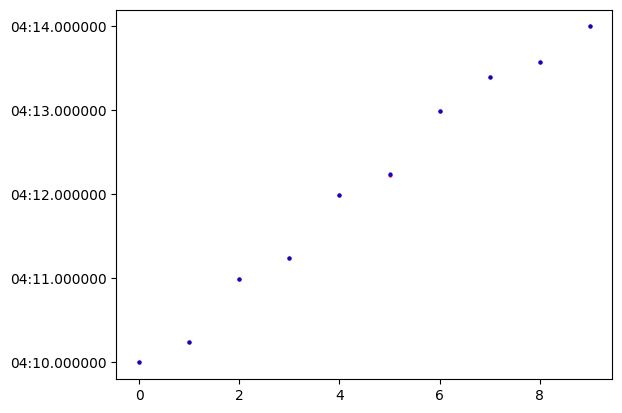

coug2/converted__SO_5.2_multi-2025-04-18-16-30-00


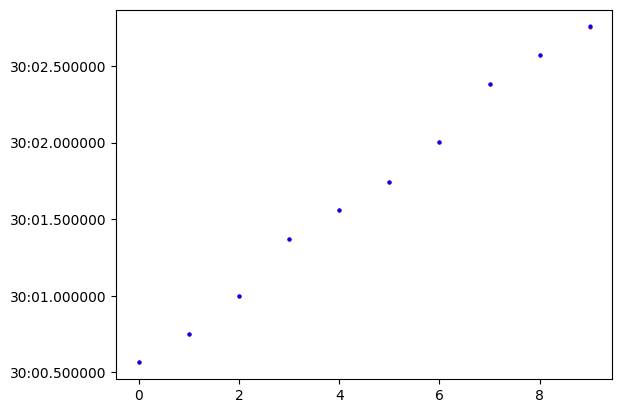

coug2/converted__SO_5.0_multi-2025-04-18-15-55-38


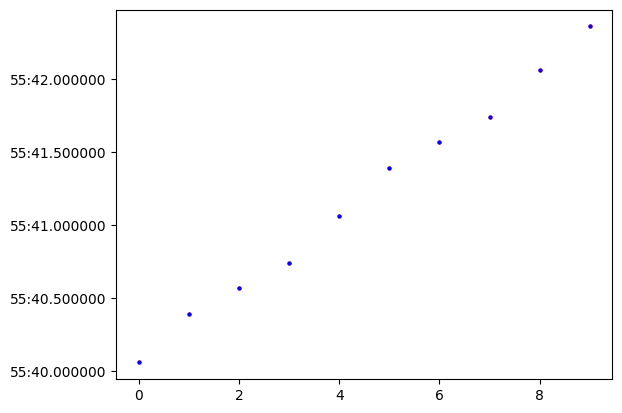

coug2/converted__SO_5.1_multi-2025-04-18-16-09-05


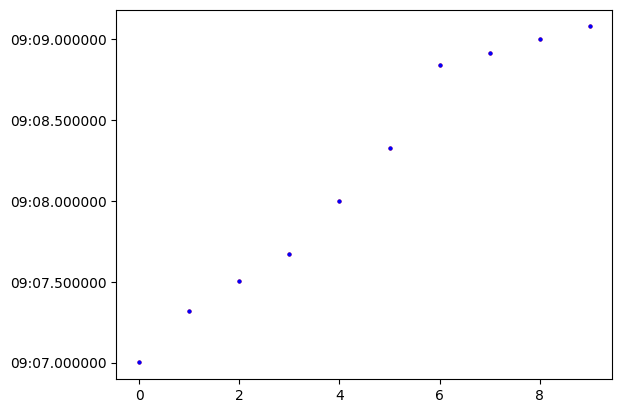

coug2/converted__SO_5.5_multi-2025-04-18-16-42-59


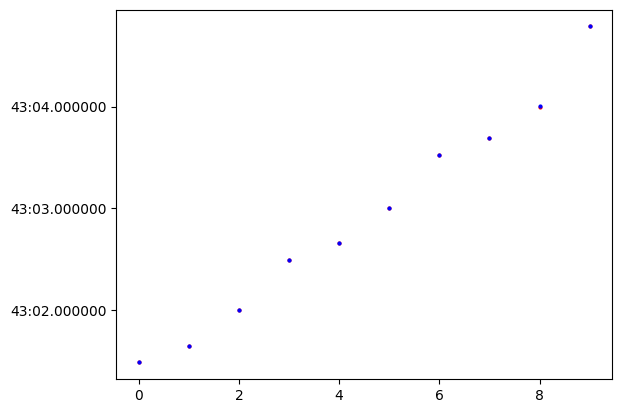

basestation/converted__test3-2025-05-01-22-03-01


In [ ]:
for path, bag in dataframes.items():
    print(path)

    # Print GPS timeline. Green = Good fix. Orange = bad fix.
    gps_fix = p_utils.get_topic(bag, "/extended_fix")
    if gps_fix is None: continue
    navsat_fix = p_utils.get_topic(bag, "/fix")
    if navsat_fix is None: continue
    # plt.plot(gps_fix["timestamp"].iloc[:20], [1]*20, 'o')
    # plt.plot(navsat_fix["timestamp"].iloc[:20], [0]*20, 'o')
    d=100
    plt.plot(range(d), gps_fix["timestamp"].iloc[:d], 'ro', markersize=2)
    plt.plot(range(d), navsat_fix["timestamp"].iloc[:d], 'bo', markersize=2)
    plt.show()

coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-00
coug3_bluey/converted__SO_5.0_multi-2025-04-04-20-07-24
coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-41
coug3_bluey/converted__SO_5.3_multi-2025-04-04-20-39-55
coug3_bluey/converted__SO_5.4_multi-2025-04-04-20-45-36
coug3_bluey/converted__SO_5.1_multi-2025-04-04-20-19-51
base_station/converted__SO_4.0_multi_base_station
base_station/converted__SO_5.2_multi
base_station/converted__SO_5.4_multi
base_station/converted__SO_2.0_base_station
base_station/converted__SO_5.1_multi
base_station/converted__SO_multi_3.0
base_station/converted__SO_5.5_multi
base_station/converted__SO_5.0_multi
coug1/converted__-2025-04-18-14-29-36


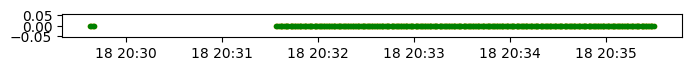

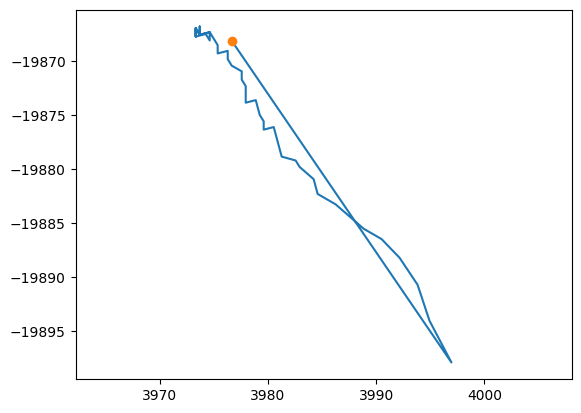

coug1/converted__so_5.0_multi-2025-04-18-15-55-38


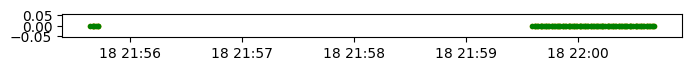

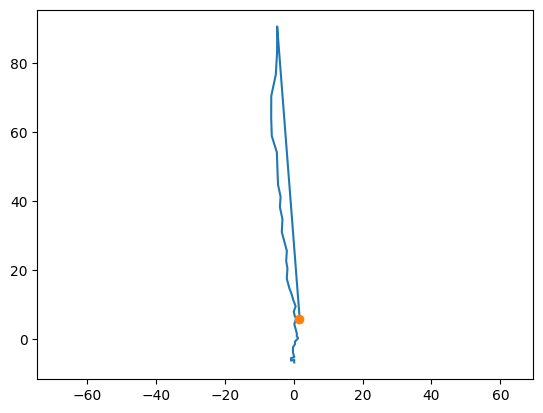

coug1/converted__so_5.5_multi-2025-04-18-16-42-57


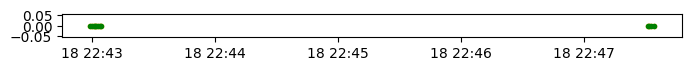

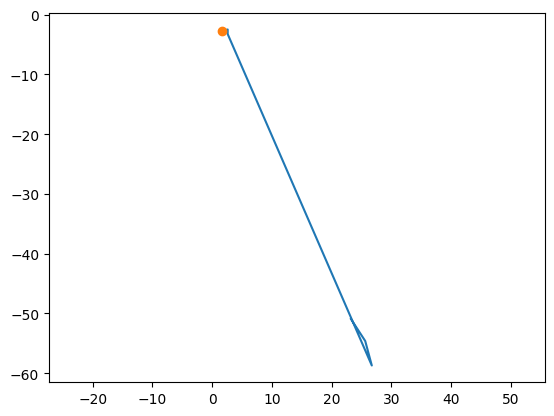

coug1/converted__SO_3.0_multi_cougs-2025-04-18-14-40-44


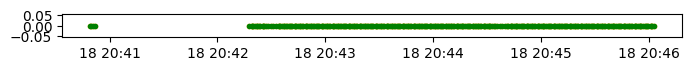

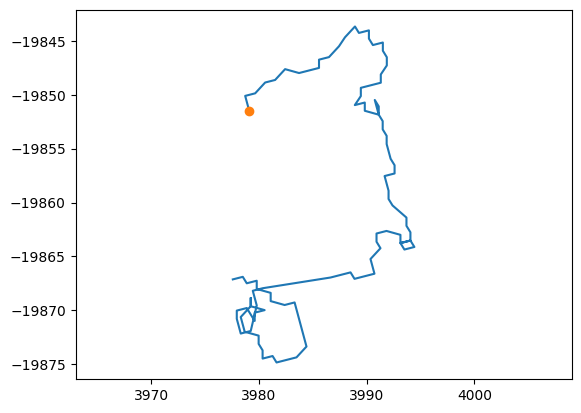

coug1/converted__so_5.1_multi-2025-04-18-16-09-08


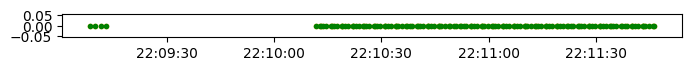

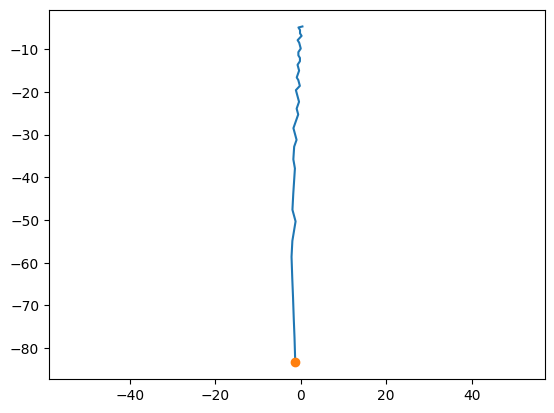

coug1/converted__so_5.4_multi-2025-04-18-16-34-01


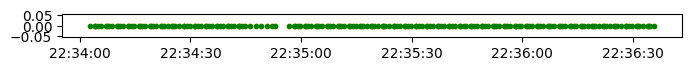

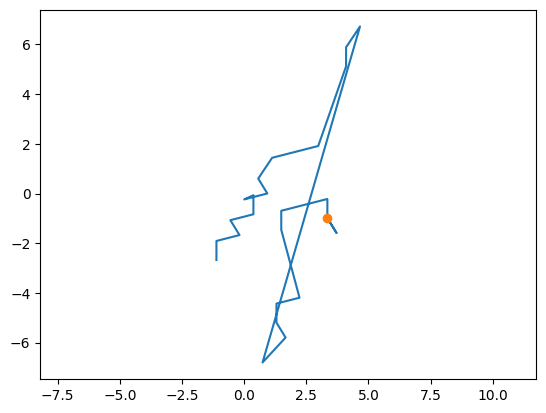

coug1/converted__so_4.0_multi-2025-04-18-15-04-05


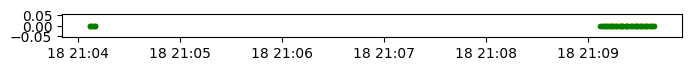

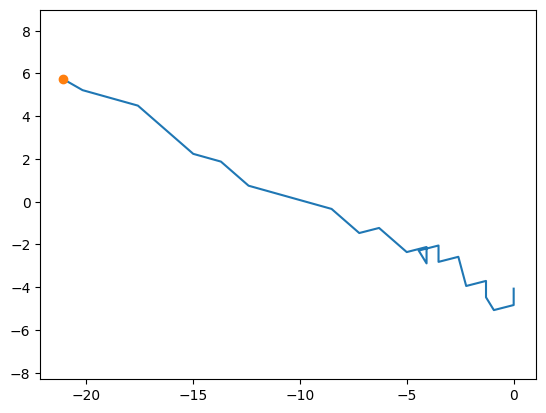

coug2/converted__SO_3.0_multi_cougs-2025-04-18-14-40-49


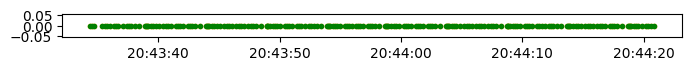

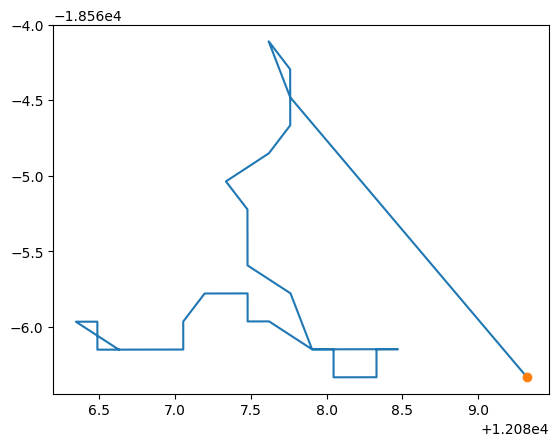

coug2/converted__SO_1.0-2025-04-18-14-04-01


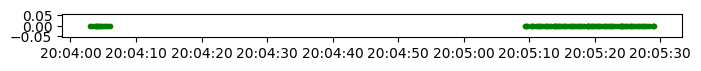

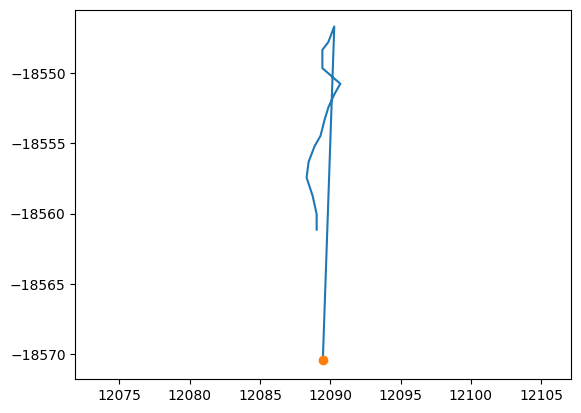

coug2/converted__SO_2.0-2025-04-18-14-15-52


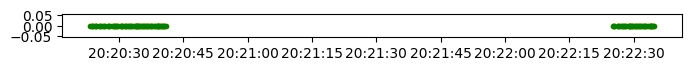

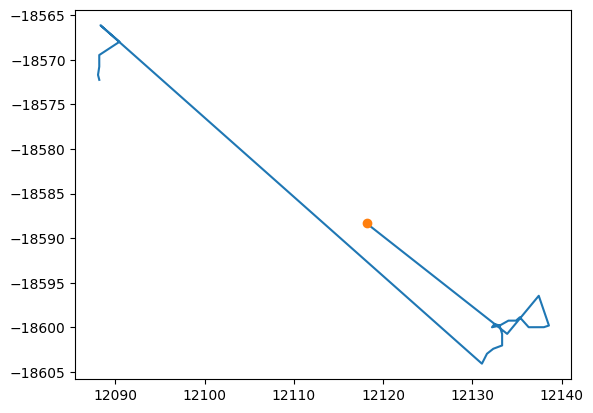

coug2/converted__SO_4.0_multi-2025-04-18-15-04-08


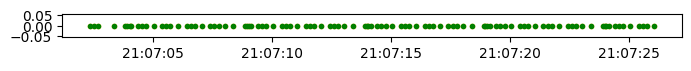

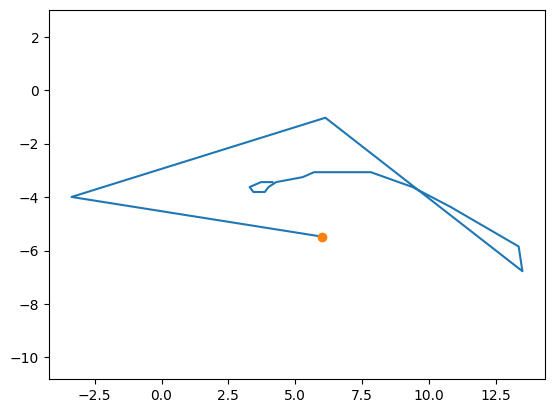

coug2/converted__SO_5.2_multi-2025-04-18-16-30-00


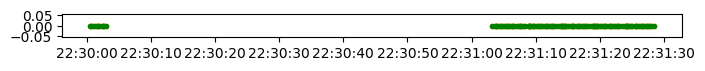

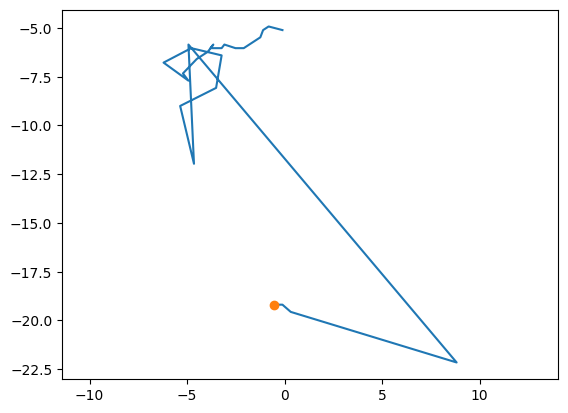

coug2/converted__SO_5.0_multi-2025-04-18-15-55-38


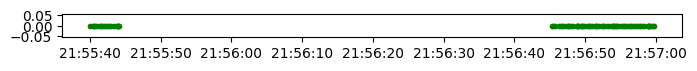

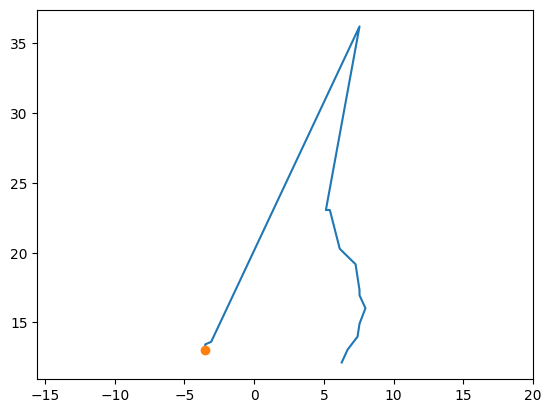

coug2/converted__SO_5.1_multi-2025-04-18-16-09-05


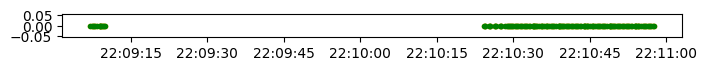

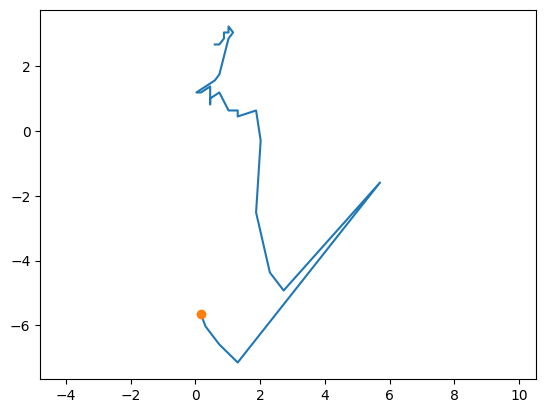

coug2/converted__SO_5.5_multi-2025-04-18-16-42-59


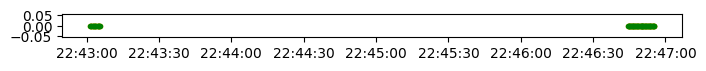

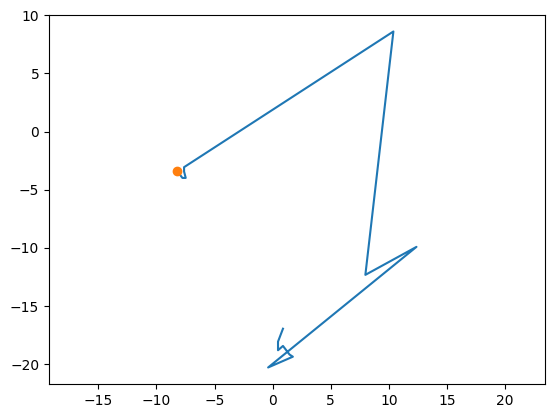

basestation/converted__test3-2025-05-01-22-03-01


In [7]:
# GPS
for path, bag in dataframes.items():
    print(path)

    # Print GPS timeline. Green = Good fix. Orange = bad fix.
    gps_fix = p_utils.get_topic(bag, "/extended_fix")
    if gps_fix is None: continue
    good_gps_mask = gps_fix["status.status"]!=-1
    good_gps_ts = gps_fix["timestamp"][good_gps_mask]
    ok_gps = gps_fix["timestamp"][gps_fix["latitude"]!=0]
    fig, ax = plt.subplots(figsize=(8, .3))
    ax.plot(ok_gps, [0]*len(ok_gps), 'o', color="orange", markersize='3')
    ax.plot(good_gps_ts, [0]*len(good_gps_ts), 'go', markersize='3')
    plt.show()
    
    gps_odom = p_utils.get_topic(bag, "/gps_odom")
    good_gps_odom = gps_odom[gps_odom["timestamp"].isin(good_gps_ts)]
    if gps_odom is None: continue
    fig, ax = plt.subplots()
    p_utils.plot_pose_w_cov(gps_odom, ax=ax)
    plt.show()

coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-00


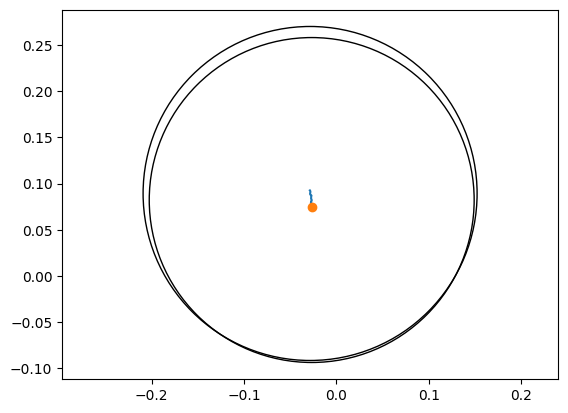

coug3_bluey/converted__SO_5.0_multi-2025-04-04-20-07-24
coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-41


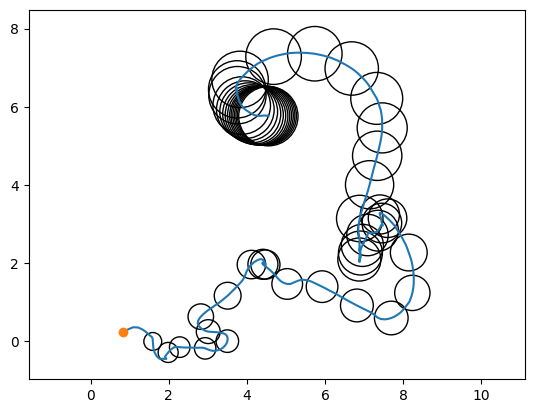

coug3_bluey/converted__SO_5.3_multi-2025-04-04-20-39-55


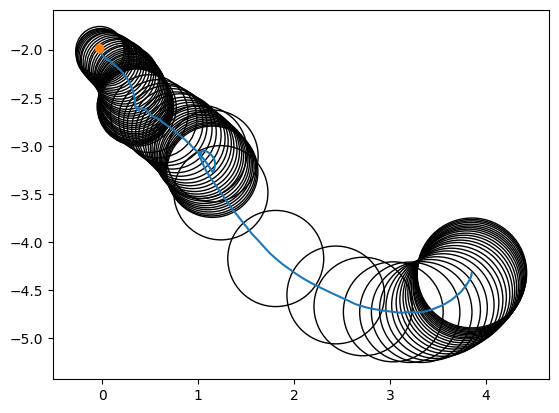

coug3_bluey/converted__SO_5.4_multi-2025-04-04-20-45-36


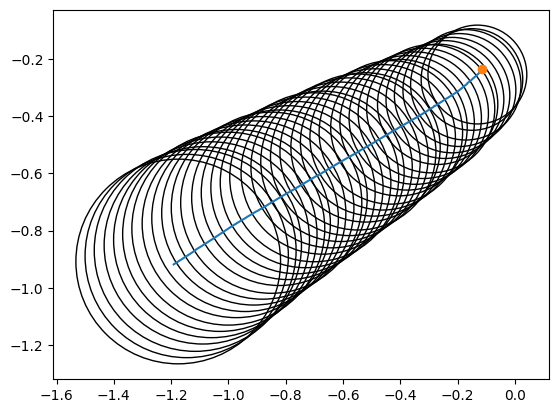

coug3_bluey/converted__SO_5.1_multi-2025-04-04-20-19-51


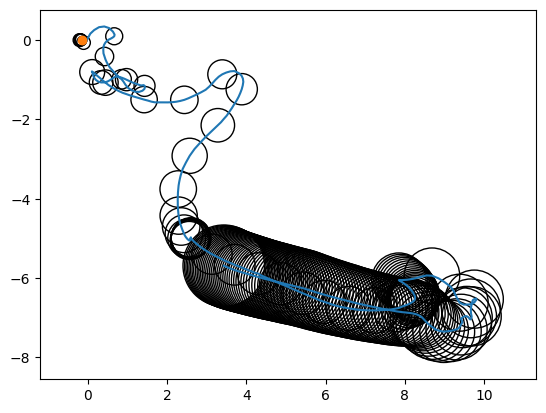

base_station/converted__SO_4.0_multi_base_station
base_station/converted__SO_5.2_multi
base_station/converted__SO_5.4_multi
base_station/converted__SO_2.0_base_station
base_station/converted__SO_5.1_multi
base_station/converted__SO_multi_3.0
base_station/converted__SO_5.5_multi
base_station/converted__SO_5.0_multi
coug1/converted__-2025-04-18-14-29-36


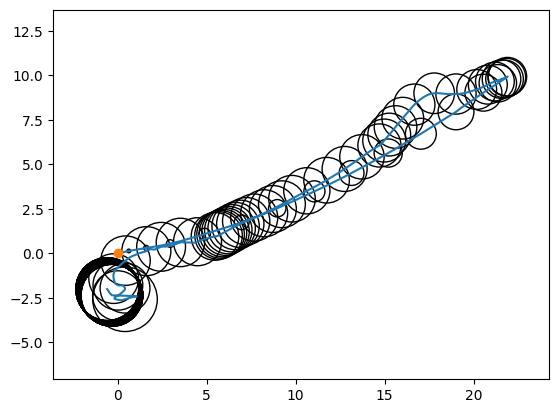

coug1/converted__so_5.0_multi-2025-04-18-15-55-38


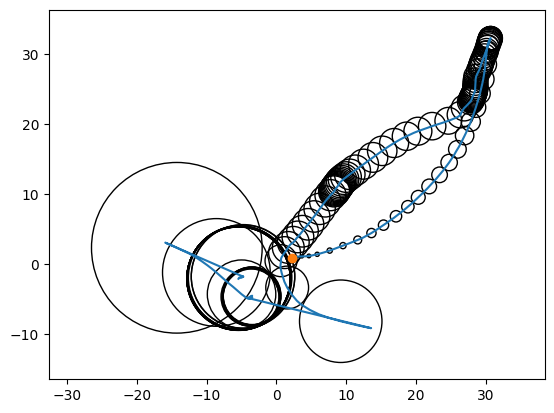

coug1/converted__so_5.5_multi-2025-04-18-16-42-57


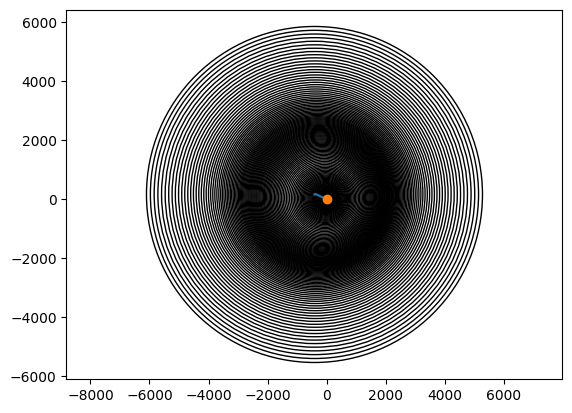

coug1/converted__SO_3.0_multi_cougs-2025-04-18-14-40-44


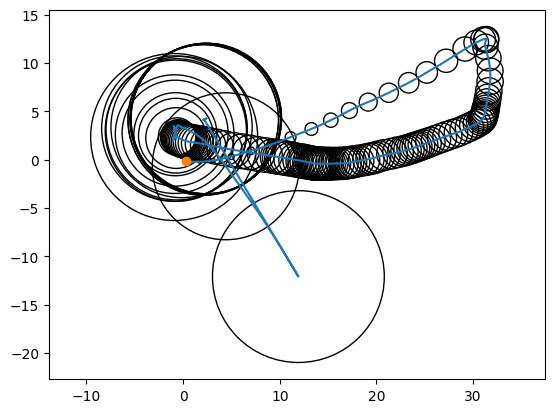

coug1/converted__so_5.1_multi-2025-04-18-16-09-08


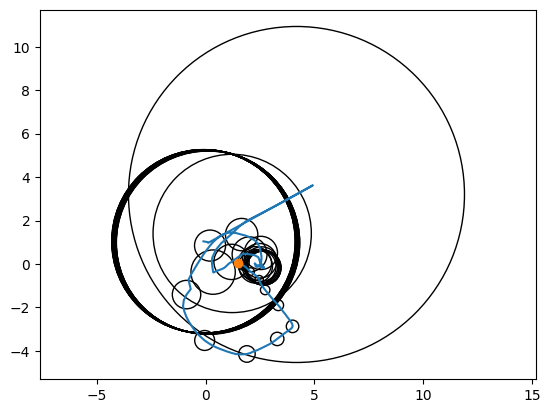

coug1/converted__so_5.4_multi-2025-04-18-16-34-01


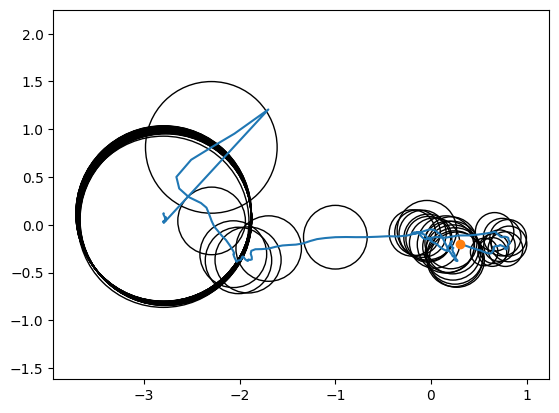

coug1/converted__so_4.0_multi-2025-04-18-15-04-05


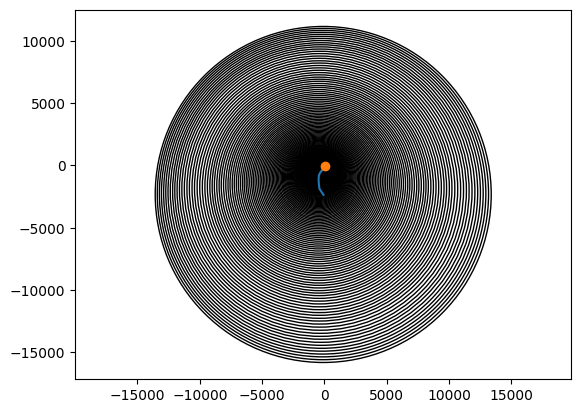

coug2/converted__SO_3.0_multi_cougs-2025-04-18-14-40-49


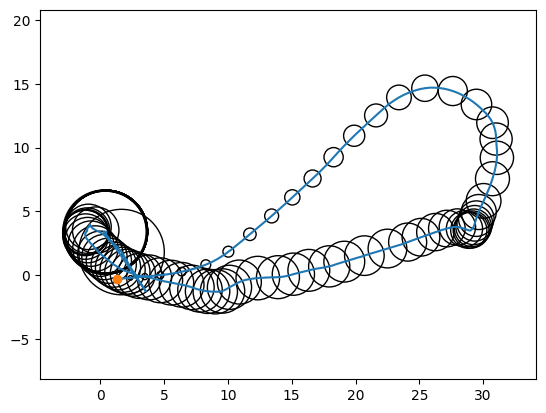

coug2/converted__SO_1.0-2025-04-18-14-04-01


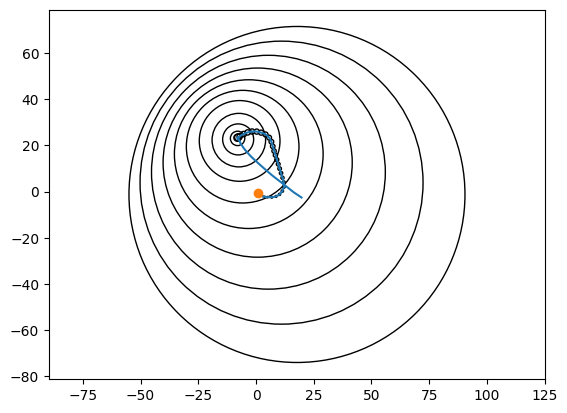

coug2/converted__SO_2.0-2025-04-18-14-15-52


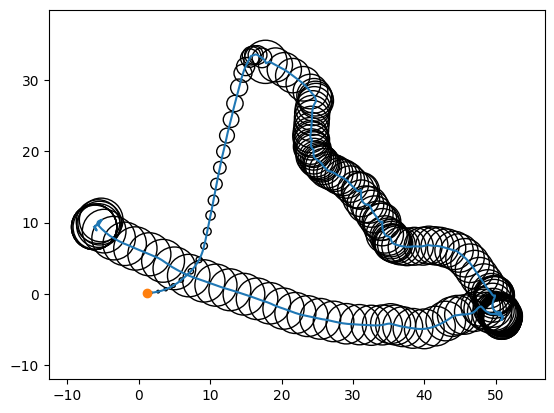

coug2/converted__SO_4.0_multi-2025-04-18-15-04-08


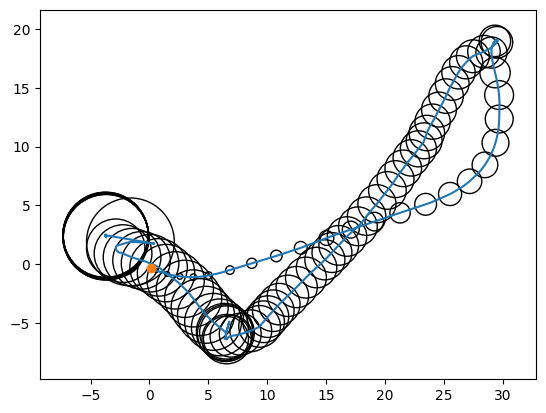

coug2/converted__SO_5.2_multi-2025-04-18-16-30-00


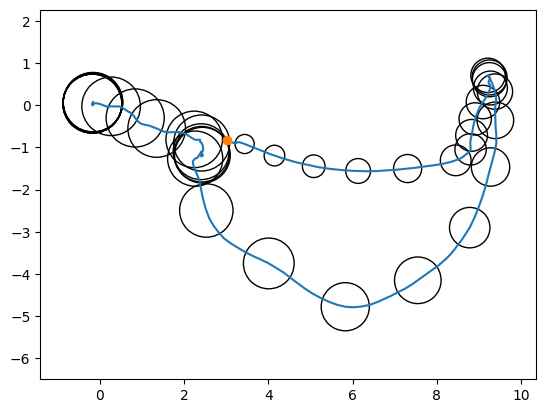

coug2/converted__SO_5.0_multi-2025-04-18-15-55-38


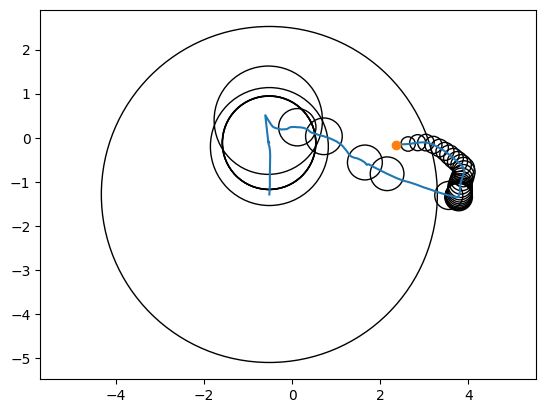

coug2/converted__SO_5.1_multi-2025-04-18-16-09-05


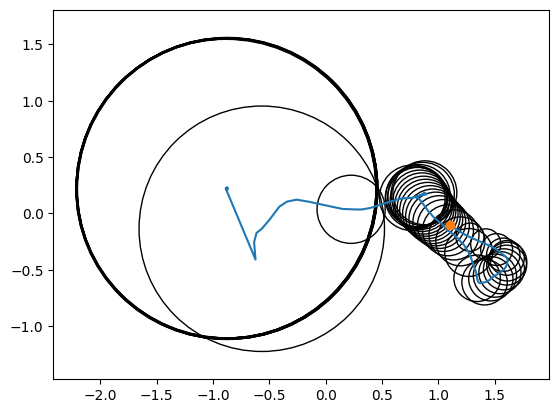

coug2/converted__SO_5.5_multi-2025-04-18-16-42-59


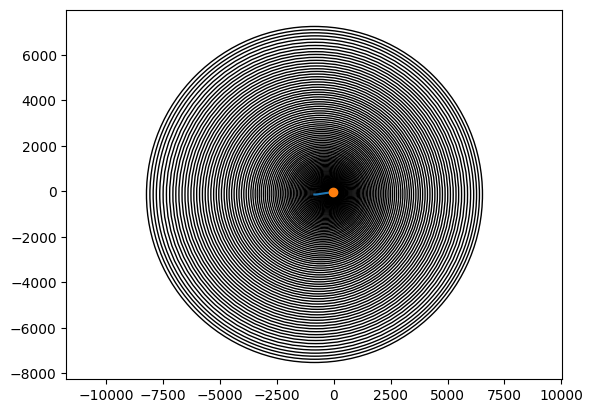

basestation/converted__test3-2025-05-01-22-03-01


In [8]:

# Plot DVL with covariance

for path, bag in dataframes.items():
    print(path)
    dvl_odom = p_utils.get_topic(bag, "/dvl/dead_reckoning")
    if dvl_odom is None: continue
    fig, ax = plt.subplots()
    ax = p_utils.plot_pose_w_cov(dvl_odom, ax=ax)
    plt.show()